<a href="https://colab.research.google.com/github/imthelizardking/CMP784--Final--Project/blob/main/lstm_working_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_datasets

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [3]:
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL2812R/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL2812R/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteL2812R/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train = train_dataset.take(4000)
test = test_dataset.take(1000)

In [6]:
# to shuffle the data ...
BUFFER_SIZE = 4000 # we will put all the data into this big buffer, and sample randomly from the buffer
BATCH_SIZE = 128  # we will read 128 reviews at a time

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [7]:
train = train.prefetch(BUFFER_SIZE)
test = test.prefetch(BUFFER_SIZE)

In [8]:
VOCAB_SIZE=1000 # assuming our vocabulary is just 1000 words

encoder = layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text)) # we just encode the text, not the labels

In [9]:
# here are the first 20 words in our 1000-word vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i', 'it',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'but', 'movie'],
      dtype='<U14')

In [10]:
example, label = list(train.take(1))[0] # that's one batch
len(example)

128

In [11]:
example[0].numpy()

b'A pale shadow of a great musical, this movie suffers from the fact that the director, Richard Attenborough, completely misses the point of the musical, needlessly "opens" it up, and muddies the thrust of the play. The show is about a group of dancers auditioning for a job in a B\'way musical and examines their drive & desire to work in this demanding and not-always-rewarding line of work. Attenborough gives us a fresh-faced cast of hopefuls, assuming that they are trying to get their "big break" in show business, rather than presenting the grittier mix of characters created on stage as a group of working "gypsies" living show to show, along with a couple of newcomers. The film has one advantage over the play and that is the opening scene, showing the size of the original audition and the true scale of shrinkage down to the 16/17 on the line (depending on how you count Cassie, who is stupidly kept out of the line in the movie). Anyone who can catch a local civic light opera production

In [12]:
encoded_example = encoder(example[:1]).numpy()
encoded_example

array([[  4,   1,   1,   5,   4,  80, 621,  11,  19,   1,  38,   2, 191,
         12,   2, 171, 692,   1, 348,   1,   2, 199,   5,   2, 621,   1,
          1,  10,  57,   3,   1,   2,   1,   5,   2, 313,   2, 120,   7,
         45,   4, 628,   5,   1,   1,  17,   4, 297,   8,   4,   1, 621,
          3,   1,  66,   1,   1,   6, 164,   8,  11,   1,   3,   1, 373,
          5, 164,   1, 374, 179,   4,   1, 185,   5,   1,   1,  12,  34,
         24, 256,   6,  76,  66, 202,   1,   8, 120,   1, 235,  71,   1,
          2,   1,   1,   5, 103,   1,  21, 949,  15,   4, 628,   5, 854,
          1, 673, 120,   6, 120, 338,  16,   4, 367,   5,   1,   2,  20,
         46,  29,   1, 126,   2, 313,   3,  12,   7,   2, 762, 134, 801,
          2,   1,   5,   2, 203,   1,   3,   2, 285,   1,   5,   1, 182,
          6,   2,   1,  21,   2, 373,   1,  21,  87,  25,   1,   1,  37,
          7,   1, 738,  44,   5,   2, 373,   8,   2,  19, 257,  37,  69,
          1,   4, 618,   1, 752,   1, 358,   5,   2

In [13]:
model = tf.keras.Sequential([
    encoder, # the encoder
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(layers.LSTM(64)), # making LSTM bidirectional
    tf.keras.layers.Dense(32, activation='relu'), # FC layer for the classification part
    tf.keras.layers.Dense(1) # final FC layer

])

In [14]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00514452]


In [15]:
# we will use binary cross entropy again because this is a binary classification task (positive or negative)
# we also did not apply a sigmoid activation function at the last FC layer, so we specify that the 
# are calculating the cross entropy from logits
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # adam optimizer is more efficient (not always the most accurate though)
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 134,209
Trainable params: 134,209
Non-trai

In [17]:
H2 = model.fit(train, epochs=25,
                    validation_data=test)

Epoch 1/25
32/32 [==============================] - 149s 4s/step - loss: 0.6930 - accuracy: 0.4967 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 2/25
32/32 [==============================] - 135s 4s/step - loss: 0.6921 - accuracy: 0.4967 - val_loss: 0.6922 - val_accuracy: 0.5030
Epoch 3/25
32/32 [==============================] - 140s 4s/step - loss: 0.6911 - accuracy: 0.4967 - val_loss: 0.6914 - val_accuracy: 0.5030
Epoch 4/25
32/32 [==============================] - 137s 4s/step - loss: 0.6892 - accuracy: 0.4967 - val_loss: 0.6896 - val_accuracy: 0.5030
Epoch 5/25
32/32 [==============================] - 151s 5s/step - loss: 0.6849 - accuracy: 0.4967 - val_loss: 0.6851 - val_accuracy: 0.5030
Epoch 6/25
32/32 [==============================] - 150s 5s/step - loss: 0.6644 - accuracy: 0.5305 - val_loss: 0.6456 - val_accuracy: 0.5590
Epoch 7/25
32/32 [==============================] - 149s 5s/step - loss: 0.5903 - accuracy: 0.6580 - val_loss: 0.5765 - val_accuracy: 0.6830
Epoch 8/25
32

In [ ]:
def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
              "Train Accuracy": H.history['accuracy'], "Validation Accuracy": H.history['val_accuracy']
             })
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

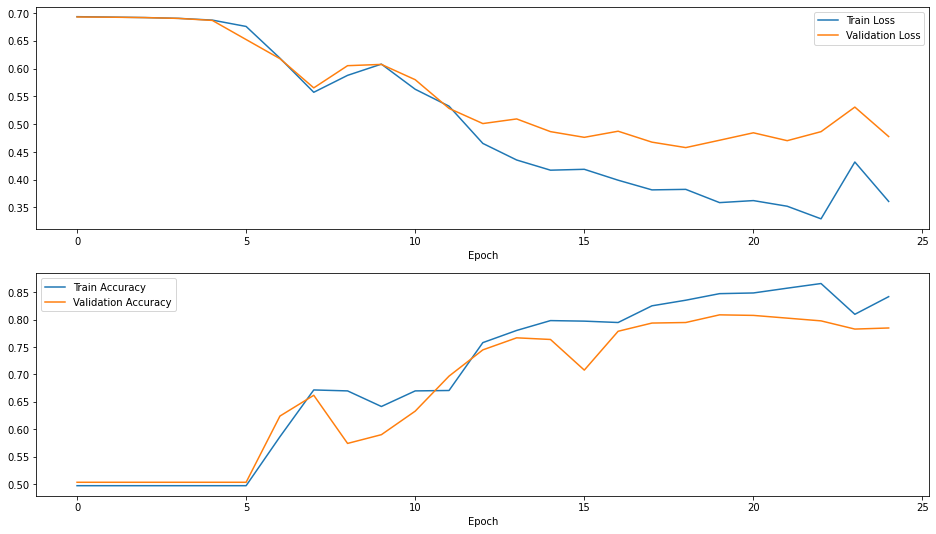

In [ ]:
plot_results(H2)